## Exploratory Data Analysis on the Dataset

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import pandas as pd
import seaborn as sns

In [16]:
# load dataset

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train Dataset:\n", train_df.head())
print("\nTest Dataset:\n", test_df.head())
print("Number of training samples:", len(train_df))
print("Number of test samples:", len(test_df))

Train Dataset:
    id  ground_truth
0   2             1
1   3             1
2   4             1
3   6             1
4   9             1

Test Dataset:
    id
0   1
1   5
2   7
3   8
4  15
Number of training samples: 3401
Number of test samples: 1459


In [17]:
# Analyze Image Dimensions and Color Channels:

sample_image_path = os.path.join(train_images_path, str(train_df["id"].iloc[0]) + ".png")
sample_image = Image.open(sample_image_path)
print("Image size:", sample_image.size)
print("Image mode (grayscale/RGB):", sample_image.mode)

Image size: (539, 528)
Image mode (grayscale/RGB): RGBA


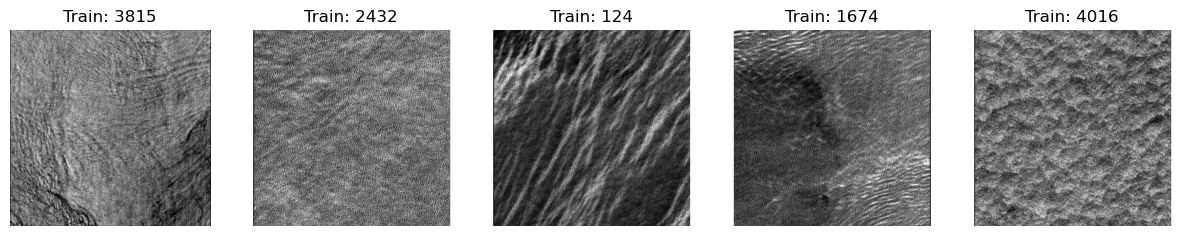

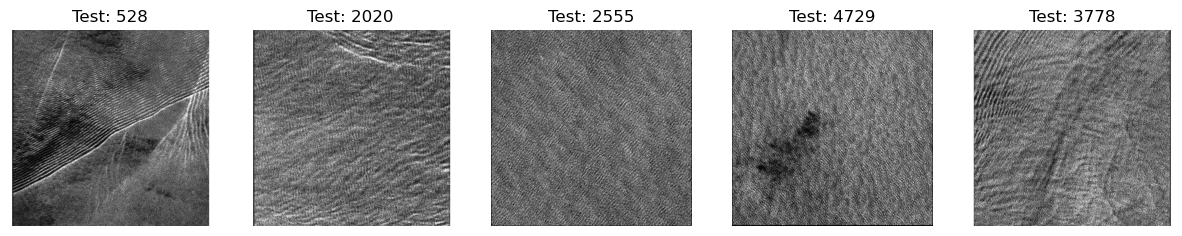

In [42]:
# Visualise Random Images from Train and Test Datasets

def visualize_images(image_ids, folder_path, n=5, dataset_name="Dataset"):
   
    plt.figure(figsize=(15, 6))
    for i in range(n):
        img_id = random.choice(image_ids)
        img_path = os.path.join(folder_path, str(img_id) + ".png")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(2, n, i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(f"{dataset_name}: {img_id}")
            plt.axis("off")
    plt.show()

# Visualize train dataset
visualize_images(train_df["id"], train_images_path, n=5, dataset_name="Train")

# Visualize test dataset
visualize_images(test_df["id"], test_images_path, n=5, dataset_name="Test")


### Statistical Analysis

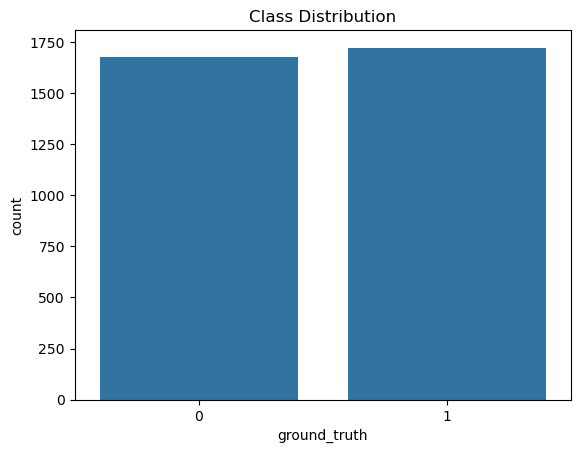

ground_truth
1    1724
0    1677
Name: count, dtype: int64


In [23]:
# 1. Class Distribution:

sns.countplot(x="ground_truth", data=train_df)
plt.title("Class Distribution")
plt.show()

# class imbalance
print(train_df["ground_truth"].value_counts())

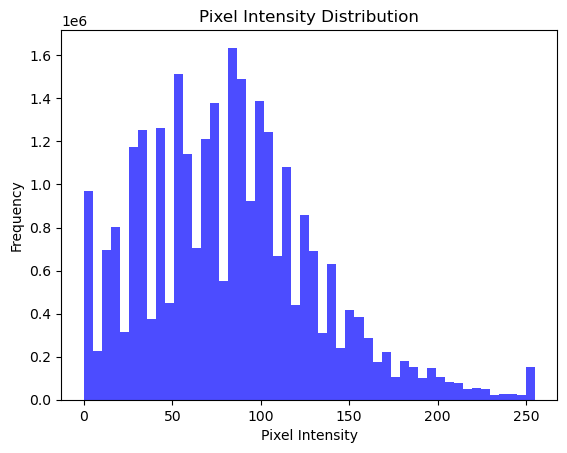

In [25]:
# 2. Image Intensity Distribution:

def analyze_image_intensity(image_ids, folder_path, n=100):
    pixel_values = []
    for img_id in image_ids[:n]:  # Limit to 100 images for analysis
        img_path = os.path.join(folder_path, str(img_id) + ".png")  # Convert img_id to string
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        pixel_values.extend(np.array(img).flatten())
    return pixel_values

pixel_values = analyze_image_intensity(train_df["id"], train_images_path)
plt.hist(pixel_values, bins=50, color="blue", alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

Unique widths: {539}
Unique heights: {528}


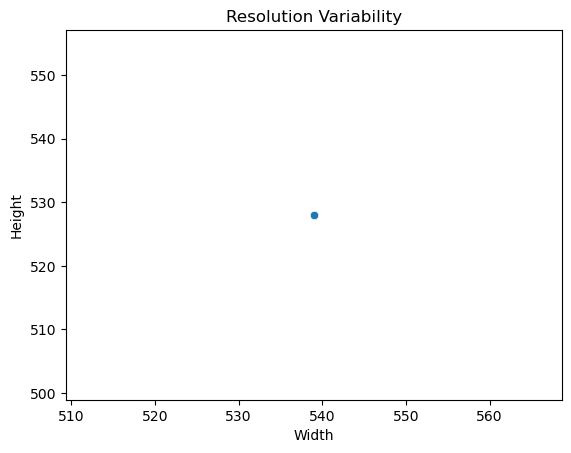

In [27]:
# 3. Resolution Variability:

resolutions = [Image.open(os.path.join(train_images_path, str(img_id) + ".png")).size for img_id in train_df["id"]]  # Convert img_id to string
widths, heights = zip(*resolutions)
print("Unique widths:", set(widths))
print("Unique heights:", set(heights))

sns.scatterplot(x=widths, y=heights)
plt.title("Resolution Variability")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

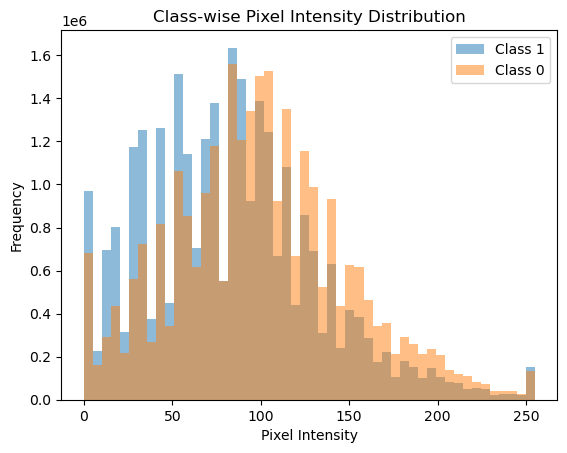

In [28]:
# 4. Correlation between Features and Ground Truth:

def class_wise_intensity(train_df, folder_path):
    class_stats = {}
    for label in train_df["ground_truth"].unique():
        class_images = train_df[train_df["ground_truth"] == label]["id"]
        pixel_values = analyze_image_intensity(class_images, folder_path)
        class_stats[label] = pixel_values
    
    for label, pixels in class_stats.items():
        plt.hist(pixels, bins=50, alpha=0.5, label=f"Class {label}")
    plt.legend()
    plt.title("Class-wise Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

class_wise_intensity(train_df, train_images_path)

### Correlational Analysis


Extracting image properties...


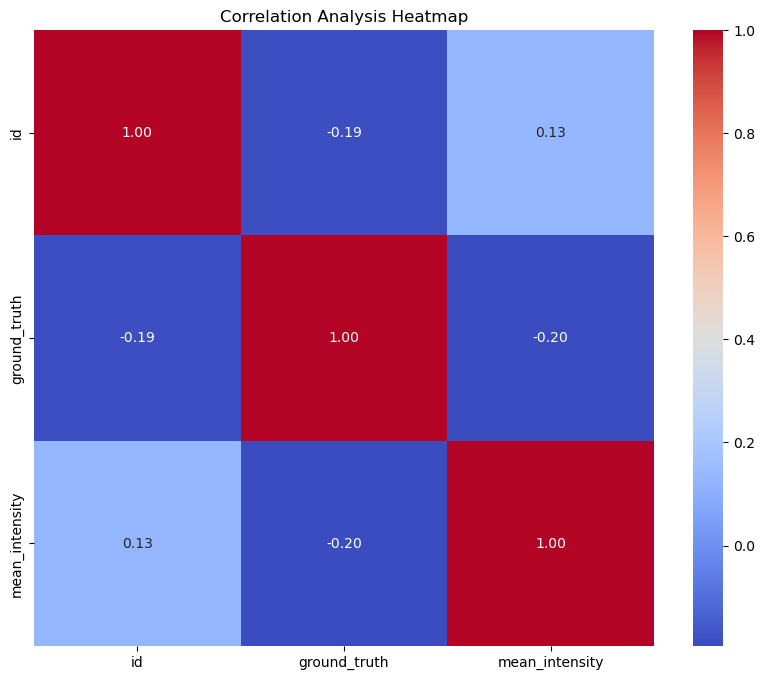


Correlation with ground_truth:
ground_truth      1.000000
id               -0.190280
mean_intensity   -0.195249
Name: ground_truth, dtype: float64


In [39]:
# Extract image sizes and calculate correlation
def get_image_properties(img_folder, img_ids):
    widths, heights = [], []  
    for img_id in img_ids:
        img_path = None
        for ext in [".png", ".jpg", ".jpeg"]:  
            temp_path = os.path.join(img_folder, str(img_id) + ext)
            if os.path.exists(temp_path):
                img_path = temp_path
                break
        if img_path:
            try:
                with Image.open(img_path) as img:
                    widths.append(img.width)
                    heights.append(img.height)
            except Exception as e:
                print(f"Warning: Could not open image {img_path}: {e}")
                widths.append(np.nan)
                heights.append(np.nan)
        else:
            print(f"Warning: Image {img_id} not found in {img_folder}")
            widths.append(np.nan)
            heights.append(np.nan)
    return widths, heights  

print("\nExtracting image properties...")
train_df["width"], train_df["height"] = get_image_properties(train_images_path, train_df["id"])

# Calculate pixel intensity means
def calculate_mean_pixel_intensity(img_folder, img_ids):
    means = []
    for img_id in img_ids:
        img_path = os.path.join(img_folder, str(img_id) + ".png")
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                img_array = np.array(img)
                means.append(np.mean(img_array))
        else:
            means.append(np.nan)
    return means

train_df["mean_intensity"] = calculate_mean_pixel_intensity(train_images_path, train_df["id"])

# Drop rows with missing values
train_df.dropna(inplace=True)

# Perform correlation analysis
correlation_matrix = train_df.drop(columns=["width", "height"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Analysis Heatmap")
plt.show()

# Correlation of ground truth with other features
if "ground_truth" in train_df.columns:
    print("\nCorrelation with ground_truth:")
    print(correlation_matrix["ground_truth"].sort_values(ascending=False))

* Weak negative correlation between id and ground_truth of -0.190280
* Weak negative correlation between mean_intensity and ground_truth of -0.195249